In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pprint import pprint

import src
from src.reload import deep_reload

In [11]:
directory = 'Outputs/Random_Experiment/'

files = os.listdir(directory)

In [324]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

places = src.graph.graph_from_json('Outputs/places.json')

pop_adj = sum([v['population'] for k, v in places._node.items()]) / len(places)

weighted = {k: v['population'] / 1e6 for k, v in places._node.items()}

relative = {k: v['population'] / pop_adj for k, v in places._node.items()}

unweighted = {k: 1 for k, v in places._node.items()}

In [334]:
deep_reload(src)

specific_impedance = lambda x, k: src.routing.impedance(
    x[4],
    origins = {k: 1},
    destinations = weighted,
    field = 'total_time',
    constant = 1 / 3600,
)

functions = {
    'capacity': lambda x: x[1]['capacity'] / 3.6e6,
    'power': lambda x: x[1]['power'] / 1e3,
    'risk_attitude': lambda x: (x[1]['risk_attitude'][0] + x[1]['risk_attitude'][1]) / 2,
    'reliability': lambda x: x[2]['station']['reliability'],
    'graph_index': lambda x: x[0],
    # 'impedance_w': lambda x: src.routing.impedance(
    #     x[4], origins = weighted, destinations = weighted, field = 'total_time',
    # ) / 3600,
    'impedance': lambda x: src.routing.impedance(
        x[4], field = 'total_time',
    ) / 3600,
    'impedance_d': lambda x: src.routing.impedance(
        x[4], field = 'driving_time',
    ) / 3600,
    'gravity': lambda x: src.routing.gravity(
        x[4],
        origins = weighted,
        destinations = weighted,
        field = 'total_time',
        adjustment = 3600,
    ),
}

def itemized_impedance(values, origins, destinations):

    out = {}

    for k, v in values.items():

        out[k] = src.routing.specific_impedance(
            v, destinations, field = 'total_time',
        ) / 3600,

    return out

In [335]:
deep_reload(src)

src.routing.gravity(
    out[4],
    origins = weighted,
    destinations = weighted,
    field = 'total_time',
    adjustment = 3600,
)

0.21584962768082888

In [336]:
paths = {}

outputs = {k: [] for k in functions.keys()}

specific_outputs_w = []
specific_outputs = []

idx = -1

success = []

for file in src.progress_bar.ProgressBar(files):

    idx += 1

    run = eval(re.findall(r'\d+', file)[0])

    if run < 9000:

        continue

    with open(directory + file, 'rb') as f:

        out = pkl.load(f)

        paths[idx] = {'sng': out[0], 'paths': out[5]}

    # try:
        
    #     specific_outputs_w.append(itemized_impedance(out[4], weighted, weighted))
    #     specific_outputs.append(itemized_impedance(out[4], unweighted, unweighted))

    # except:

    #     pass

    keep = True
    
    for key, fun in functions.items():

        try:

            outputs[key].append(fun(out))

        except:

            outputs[key].append(0)

            keep = False

    if keep:
        
        success.append(idx)

 [------->] (1500/1500) 100.00%, 26.85 it/s, 55.89 s elapsed, 0.00 s remaining

In [337]:
for key, val in outputs.items():

    outputs[key] = np.array(val)[success]

In [338]:
outputs_norm = outputs.copy()

keys = ['capacity', 'power', 'risk_attitude', 'reliability']

for key in keys:

    value = outputs[key]

    outputs_norm[key] = (np.array(value) - min(value)) / (max(value) - min(value))

df = pd.DataFrame(data = outputs_norm)

In [339]:
df

,capacity,power,risk_attitude,reliability,graph_index,impedance,impedance_d,gravity
0,0.806164,0.198592,0.743107,0.757193,1,6.379178,5.945368,0.217817
1,0.120421,0.842922,0.540876,0.090148,2,6.847139,5.982055,0.211560
2,0.295603,0.763750,0.653462,0.894414,0,6.350287,5.943737,0.217167
3,0.978382,0.857539,0.777689,0.753748,0,6.178738,5.939805,0.218345
4,0.627118,0.397679,0.907149,0.579351,2,6.584950,5.956088,0.216675
...,...,...,...,...,...,...,...,...
1491,0.452756,0.233792,0.442470,0.426678,2,6.541213,5.947190,0.216624
1492,0.050553,0.876474,0.815518,0.985566,1,6.615473,6.017510,0.213153
1493,0.572331,0.059859,0.918944,0.531069,0,6.642909,5.950748,0.216688
1494,0.312868,0.713869,0.875568,0.092247,1,6.518535,5.952659,0.216697


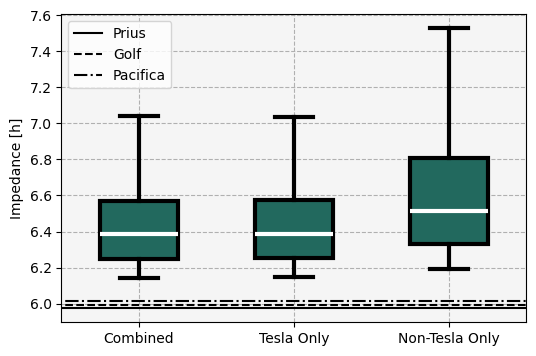

In [399]:
x = [
    df[df['graph_index'] == 0]['impedance'],
    df[df['graph_index'] == 1]['impedance'],
    df[df['graph_index'] == 2]['impedance'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'showfliers': False,
    'boxprops': {
        'fc': '#22695e',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': 'white',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 1.5,
}

kw['label'] = 'Prius'
kw['ls'] = '-'
ax.plot([-1, 4], [5.974227228704856, 5.974227228704856], **kw)

kw['label'] = 'Golf'
kw['ls'] = '--'
ax.plot([-1, 4], [5.992354190847054, 5.992354190847054], **kw)

kw['label'] = 'Pacifica'
kw['ls'] = '-.'
ax.plot([-1, 4], [6.012984648570297, 6.012984648570297], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    # 'yticks': np.arange(4, 7.25, .1),
    'xlim': (.5, 3.5),
    # 'ylim': (6, 8),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_Impedance.png', bbox_inches = 'tight', dpi = 300)

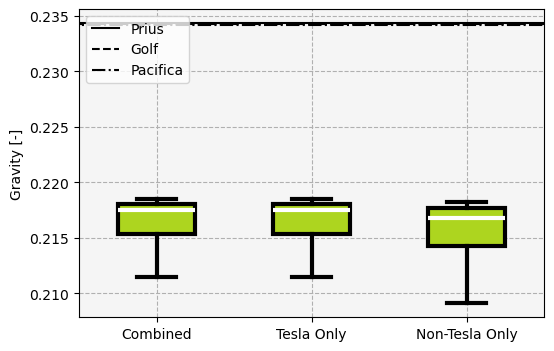

In [398]:
x = [
    df[df['graph_index'] == 0]['gravity'],
    df[df['graph_index'] == 1]['gravity'],
    df[df['graph_index'] == 2]['gravity'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'showfliers': False,
    'boxprops': {
        'fc': '#add51f',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': 'white',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 1.5,
}

kw['label'] = 'Prius'
kw['ls'] = '-'
ax.plot([-1, 4], [0.23433277441564093] * 2, **kw)

kw['label'] = 'Golf'
kw['ls'] = '--'
ax.plot([-1, 4], [0.2342746366555934] * 2, **kw)

kw['label'] = 'Pacifica'
kw['ls'] = '-.'
ax.plot([-1, 4], [0.23417673624763774] * 2, **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Gravity [-]',
    # 'yticks': np.arange(4, 7.25, .1),
    'xlim': (.5, 3.5),
    # 'ylim': (6, 8),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_Gravity.png', bbox_inches = 'tight', dpi = 300)

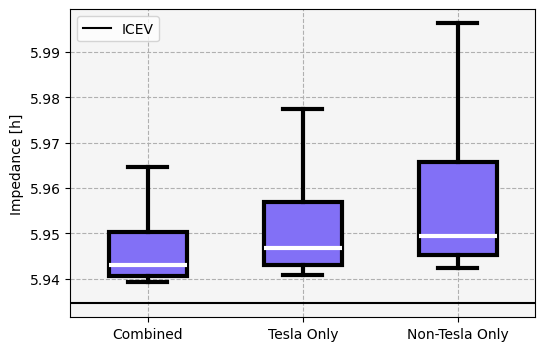

In [397]:
x = [
    df[df['graph_index'] == 0]['impedance_d'],
    df[df['graph_index'] == 1]['impedance_d'],
    df[df['graph_index'] == 2]['impedance_d'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'showfliers': False,
    'boxprops': {
        # 'fc': '#22695e',
        # 'fc': '#add51f',
        'fc': '#8270f6',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': 'white',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 1.5,
}

kw['label'] = 'ICEV'
kw['ls'] = '-'
ax.plot([-1, 4], [5.934570521146484, 5.934570521146484], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    # 'yticks': np.arange(4.1, 4.3, .025),
    'xlim': (.5, 3.5),
    # 'ylim': (4.59, 4.65),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_Impedance_Driving.png', bbox_inches = 'tight', dpi = 300)

In [201]:
cities_california = src.graph.subgraph(
    cities, [n for n in cities.nodes if '(State Line)' not in n]
)

In [202]:
pacifica_sri = np.array([10.81331175,  9.08769618,  7.56235954,  6.73363645,  5.18683418,
        4.69314255,  5.12188198,  4.88346958,  3.88588944,  3.28200579,
        2.77253372,  4.13586792])

In [448]:
deep_reload(src)

alpha = .05

graph_index = 0

df_sel = df[(df['graph_index'] == graph_index)]
# df_sel = df.copy()

formula = (
    'impedance ~ ' +
    'C(graph_index) * ' + 
    'capacity * ' + 
    'power * ' + 
    'reliability * ' +
    'risk_attitude'
)

model = smf.ols(formula, data = df_sel).fit()

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.model_anova_tabular(
    model, df_sel, 'impedance', 4, c = int(len(df_sel['graph_index'].unique())),
)

print(out_string)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string = src.analysis.significant_parameters_tabular(
    model, alpha = alpha,
    label_substitutions = label_substitutions
)

print(out_string)

4 16 1
484 15 499
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.926 & 0.858 & 0.853 & 0.000 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 28.706 & 15 & 1.914 \\
\hline Error & 4.754 & 484 & 0.010 \\
\hline Total & 33.460 & 499 & 0.067 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{194.848} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None
\hline {\small Intercept } & 7.121 & 0.000 \\
\hline {\small power } & -1.009 & 0.000 \\
\hline {\small capacity } & -1.031 & 0.000 \\
\hline {\small reliability } & -0.227 & 0.040 \\
\hline {\small capacity:power } & 0.984 & 0.000 \\
\hline {\small capacity:reliability } & 0.422 & 0.036 \\



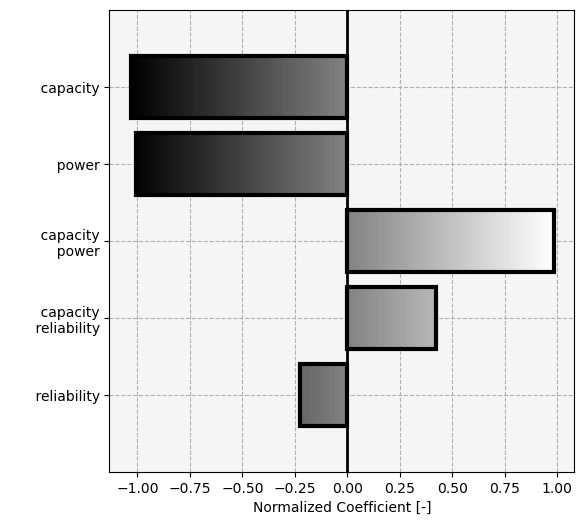

In [451]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_dict = src.analysis.significant_parameters(
    model, alpha = alpha, just = 15,
    label_substitutions = label_substitutions
)

out_dict.pop('Intercept'.rjust(15))

for key, val in out_dict.items():

    val['key'] = key

out_list = np.flip(sorted(out_dict.values(), key = lambda x: np.abs(x['coefficient'])))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'ec': 'k',
    'fc': 'none',
    'lw': 3,
    'zorder': 4,
}

vmin = min([v['coefficient'] for v in out_dict.values()])
vmax = max([v['coefficient'] for v in out_dict.values()])

cmap = src.figures.colormap(["#000000", "#ffffff"])
# cmap = src.figures.colormap("viridis")
# cmap = src.figures.colormap("autumn")

idx = len(out_dict) - 1

for value in out_list:

    c = value['coefficient']

    bounds = ((c - vmin) / (vmax - vmin), (0 - vmin) / (vmax - vmin))
    gradient = np.atleast_2d(np.linspace(bounds[1], bounds[0], 1000))

    bars = ax.barh(idx, width = c, **kw)
    bar = bars[0]
    
    x, y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    ax.imshow(
        gradient,
        cmap = cmap,
        extent=[x, x + w, y , y + h],
        aspect="auto",
        zorder = 3,
        vmin = 0,
        vmax = 1,
    )

    idx -= 1

kw = {
    'color': 'k',
    'lw': 2,
    'ls': '-',
    'zorder': 4,
}

ax.plot([0, 0], [-1, len(out_list)], **kw)

kw = {
    'yticks': list(range(len(out_dict))),
    'xlabel': 'Normalized Coefficient [-]',
    'yticklabels': np.flip([v['key'].replace(':', ':\n') for v in out_list]),
    'facecolor': 'whitesmoke',
    'ylim': (-1, len(out_list)),
    'xlim': (1.1 * vmin, 1.1 * vmax),
    # 'xticks': np.arange(-1.7, 1.1, .2),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)
# 
fig.savefig(f'Paper/figs/significant_parameters_{graph_index}.png', bbox_inches = 'tight', dpi = 300)

In [366]:
stations_used_sng = {
    0: {},
    1: {},
    2: {},
}

for idx, values in paths.items():

    path_collection = values['paths']
    sng = values['sng']

    for path_col in path_collection.values():

        for path in path_col.values():

            for p in path:

                if p in stations_used_sng[sng]:

                    stations_used_sng[sng][p] += 1

                else:

                    stations_used_sng[sng][p] = 1

In [367]:
stations_used = {}

graph_index = df['graph_index'].to_numpy()

for idx, values in paths.items():

    path_collection = values['paths']

    for path_col in path_collection.values():

        for path in path_col.values():

            for p in path:

                if p in stations_used:

                    stations_used[p] += 1

                else:

                    stations_used[p] = 1

In [368]:
len(stations_used_sng[0]), len(stations_used_sng[1]), len(stations_used_sng[2])

(456, 198, 364)

In [369]:
graph = src.graph.graph_from_json('Outputs/sng_combined.json')
nodes = graph._node

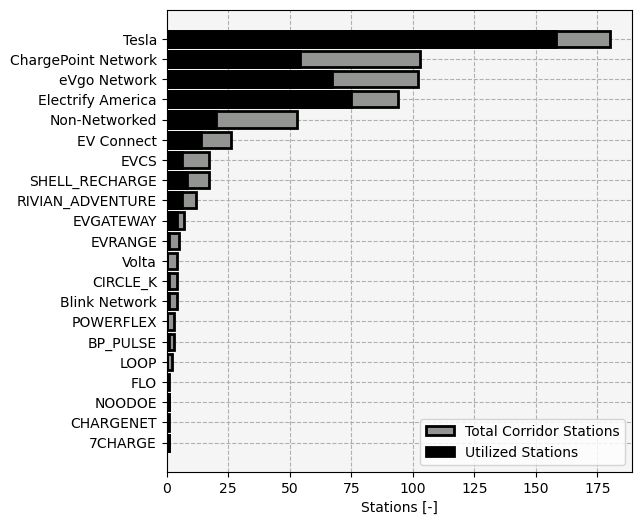

In [419]:
nodes = graph._node

stations_used = stations_used_sng[0]

networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

ung, ungc = np.unique(networks_general, return_counts = True)
un, unc = np.unique(network, return_counts = True)

indices = np.argsort(ungc)

utilization = {}

for idx in indices:

    utilization[ung[idx]] = {'total': ungc[idx], 'utilized': sum(unc[un == ung[idx]])}

x = np.array(list(range(len(ungc))))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': 'xkcd:gray',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, [v['total'] for v in utilization.values()], **kw)


kw = {
    'color': 'xkcd:black',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, [v['utilized'] for v in utilization.values()], **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': ung[indices],
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

fig.savefig('Paper/figs/corridor_station_utilization_0.png', bbox_inches = 'tight', dpi = 300)

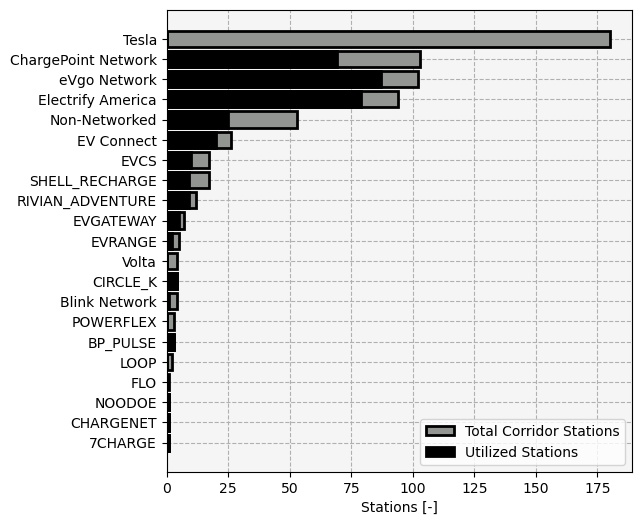

In [417]:
nodes = graph._node

stations_used = stations_used_sng[2]

networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

ung, ungc = np.unique(networks_general, return_counts = True)
un, unc = np.unique(network, return_counts = True)

indices = np.argsort(ungc)

utilization = {}

for idx in indices:

    utilization[ung[idx]] = {'total': ungc[idx], 'utilized': sum(unc[un == ung[idx]])}

x = np.array(list(range(len(ungc))))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': 'xkcd:gray',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, [v['total'] for v in utilization.values()], **kw)


kw = {
    'color': 'xkcd:black',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, [v['utilized'] for v in utilization.values()], **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': ung[indices],
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

fig.savefig('Paper/figs/corridor_station_utilization_2.png', bbox_inches = 'tight', dpi = 300)

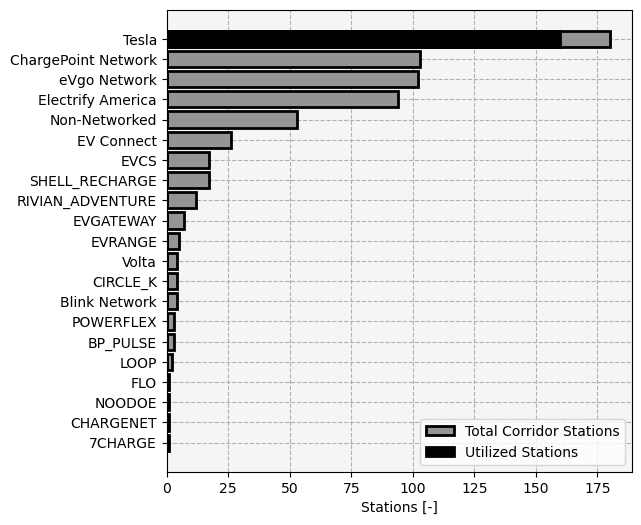

In [418]:
nodes = graph._node

stations_used = stations_used_sng[1]

networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

ung, ungc = np.unique(networks_general, return_counts = True)
un, unc = np.unique(network, return_counts = True)

indices = np.argsort(ungc)

utilization = {}

for idx in indices:

    utilization[ung[idx]] = {'total': ungc[idx], 'utilized': sum(unc[un == ung[idx]])}

x = np.array(list(range(len(ungc))))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': 'xkcd:gray',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, [v['total'] for v in utilization.values()], **kw)


kw = {
    'color': 'xkcd:black',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, [v['utilized'] for v in utilization.values()], **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': ung[indices],
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

fig.savefig('Paper/figs/corridor_station_utilization_1.png', bbox_inches = 'tight', dpi = 300)

In [375]:
graph_empty = src.graph.graph_from_json('Outputs/graph_empty.json')

In [376]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [377]:
atlas = src.graph.graph_from_json('atlas.json')

In [511]:
sng_combined = src.graph.graph_from_json('Outputs/sng_combined.json')

In [565]:
places = [n for n in sng_combined.nodes if 'station' not in n]

bcs = nx.centrality.betweenness_centrality_subset(
    sng_combined,
    sources = places,
    targets = places,
    weight = 'time',
    normalized = True,
)

In [585]:
stations_used = stations_used_sng[0]

data = {}

data['utilization'] =  np.log(
    [v for k, v in stations_used.items() if 'station' in k], dtype = float,
)
# data['utilization'] /= data['utilization'].max()

data['redundancy'] =  np.log(
    [_node[k]['n_dcfc'] for k, v in stations_used.items() if 'station' in k],
    dtype = float,
)
# data['redundancy'] /= data['redundancy'].max()

data['centrality'] =  np.array(
    [bcs[k] for k, v in stations_used.items() if 'station' in k]
)
data['centrality'] /= data['centrality'].max()

df = pd.DataFrame(data = data)

deep_reload(src)

alpha = 1

formula = (
    'utilization ~ ' +
    'redundancy * ' + 
    'centrality'
)

model = smf.ols(formula, data = df).fit()

out_string=src.analysis.model_anova_tabular(
    model, df, 'utilization', 2, c = 1,
)

print(out_string)

out_string = src.analysis.significant_parameters_tabular(
    model, alpha = alpha,
    label_substitutions = label_substitutions
)

print(out_string)

2 4 1
414 3 417
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.614 & 0.377 & 0.371 & 0.005 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 1135.565 & 3 & 378.522 \\
\hline Error & 1873.617 & 414 & 4.526 \\
\hline Total & 3009.182 & 417 & 7.216 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{83.639} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None
\hline {\small Intercept } & 1.919 & 0.000 \\
\hline {\small redundancy } & 1.518 & 0.000 \\
\hline {\small centrality } & 1.181 & 0.330 \\
\hline {\small redundancy:centrality } & 0.987 & 0.098 \\



In [70]:
utilized = [k for k, v in stations_used.items() if 'station' in k]

sng_utilized = src.graph.subgraph(graph, utilized)

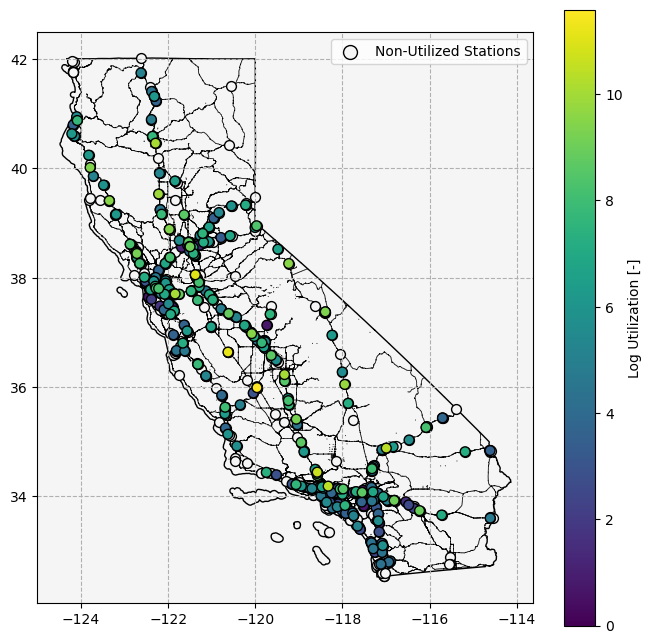

In [383]:
stations_used = stations_used_sng[2]

utilized = [k for k, v in stations_used.items() if 'station' in k]

sng_utilized = src.graph.subgraph(graph_empty, utilized)

for source, node in sng_utilized._node.items():

    node['n_utilized'] = np.log(stations_used[source])

fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': 'whitesmoke',
        'zorder': 1,
        'label': 'Non-Utilized Stations',
    },
}

# src.figures.plot_graph(graph_empty, ax = ax, **kw)
src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'show_links': False,
    'node_field': 'n_utilized',
    'scatter': {
        's': 50,
        'ec': 'k',
        # 'fc': '#72e5ef',
        'zorder': 2,
        # 'label': 'Utilized Stations',
    },
    'colorbar': {
        'label': 'Log Utilization [-]',
        # 'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(sng_utilized, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

# fig.savefig('Paper/figs/California_SNG_Utilization.png', bbox_inches = 'tight', dpi = 300)

In [194]:
places = src.graph.graph_from_json('Outputs/places.json')

In [209]:
specific_impedances_w = {k: [] for k in places.nodes}
specific_impedances = {k: [] for k in places.nodes}

for idx, val in enumerate(specific_outputs):
    for k, v in specific_impedances_w.items():

        v.append(val[k][0])

    for k, v in specific_impedances.items():

        v.append(val[k][0])

In [210]:
np.mean(specific_impedances['community_0']), np.median(specific_impedances['community_0'])

(5.453801482748693, 5.379079226778679)

In [232]:
icev_si = pkl.load(open('icev_si.pkl', 'rb'))

In [239]:
icev_si_w = pkl.load(open('icev_si_w.pkl', 'rb'))

In [240]:
for source, node in places._node.items():

    node['sa_mean_w'] = (
        (np.mean(specific_impedances_w[source]) - icev_si_w['pacifica'][source]) /
        icev_si_w['pacifica'][source]
    )
    node['sa_std_w'] = np.std(specific_impedances_w[source])
    node['sa_median_w'] = np.median(specific_impedances_w[source])

    node['sa_mean'] = (
        (np.mean(specific_impedances[source]) - icev_si['pacifica'][source]) /
        icev_si['pacifica'][source]
    )
    node['sa_std'] = np.std(specific_impedances[source])
    node['sa_median'] = np.median(specific_impedances[source])

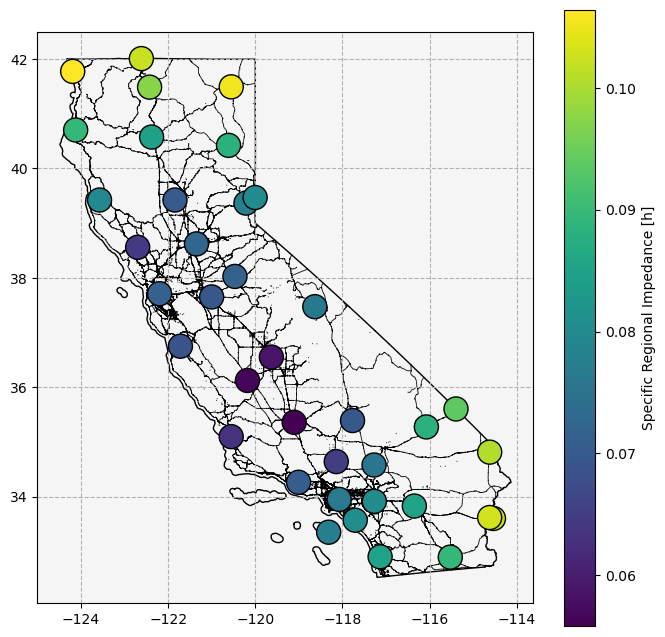

In [243]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)


kw = {
    'show_links': False,
    'node_field': 'sa_mean',
    'scatter': {
        's': 300,
        'ec': 'k',
        'zorder': 2,
    },
    'colorbar': {
        'label': 'Specific Regional Impedance [h]',
    },
}

src.figures.plot_graph(places, ax = ax, **kw)

# fig.savefig('Paper/figs/California_SNG_Utilization.png', bbox_inches = 'tight', dpi = 300)

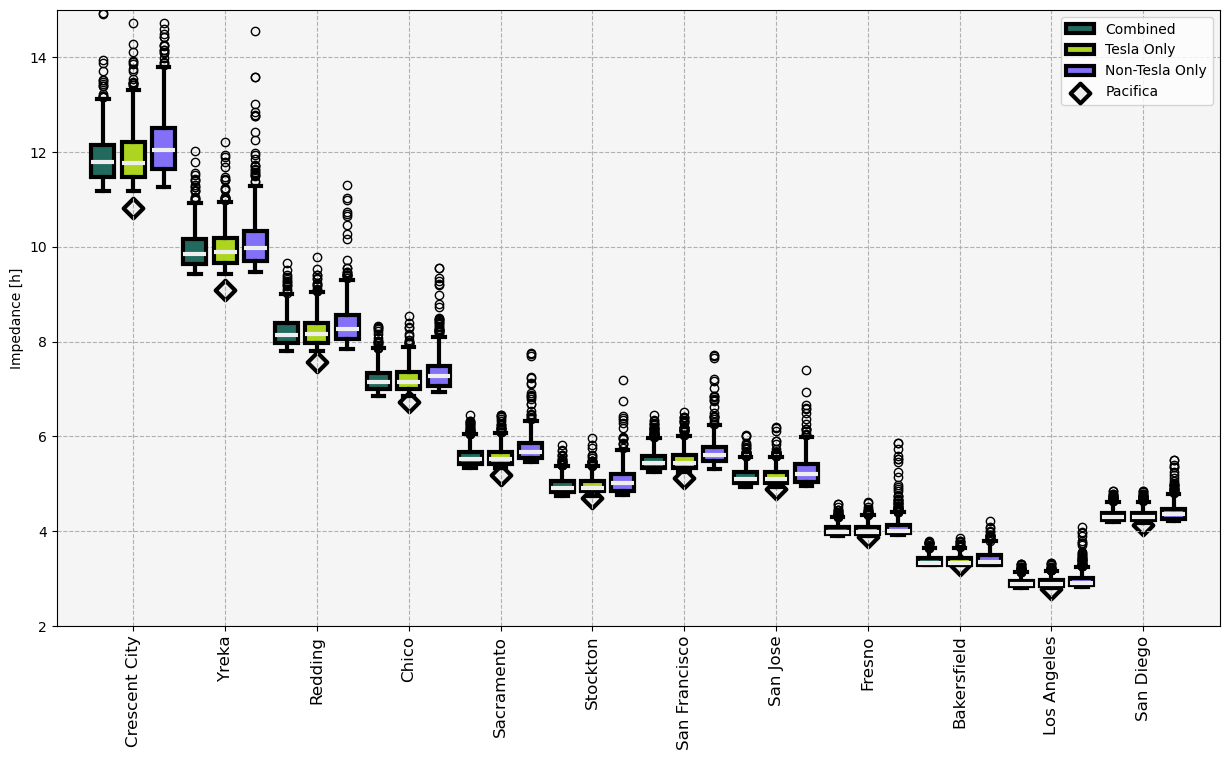

In [203]:
x0 = [df[df['graph_index'] == 0][k] for k in cities_california.nodes]
x1 = [df[df['graph_index'] == 1][k] for k in cities_california.nodes]
x2 = [df[df['graph_index'] == 2][k] for k in cities_california.nodes]

fig, ax = plt.subplots(1, 1, figsize = (15, 8))

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#22695e',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp0 = ax.boxplot(x0, positions = np.arange(0, 12, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#add51f',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp1 = ax.boxplot(x1, positions = np.arange(.33, 12.33, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#8270f6',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp2 = ax.boxplot(x2, positions = np.arange(.66, 12.66, 1), **kw)

kw = {
    'ec': 'k',
    'fc': '#eeeeee',
    'marker': 'D',
    'lw': 3,
    's': 100,
    'label': 'Pacifica',
}

sc0 = ax.scatter(np.arange(.33, 12.33, 1), pacifica_sri, **kw)

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'ylim': (2, 15),
}

_ = ax.set(**kw)

_ = ax.set_xticks(np.arange(.33, 12.33, 1))
_ = ax.set_xticklabels(list(cities_california.nodes), rotation = 90, fontsize = 12)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], sc0],
    ['Combined', 'Tesla Only', 'Non-Tesla Only', 'Pacifica'],
    loc = 'upper right',
)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Specific_Impedance_1.png', bbox_inches = 'tight', dpi = 300)

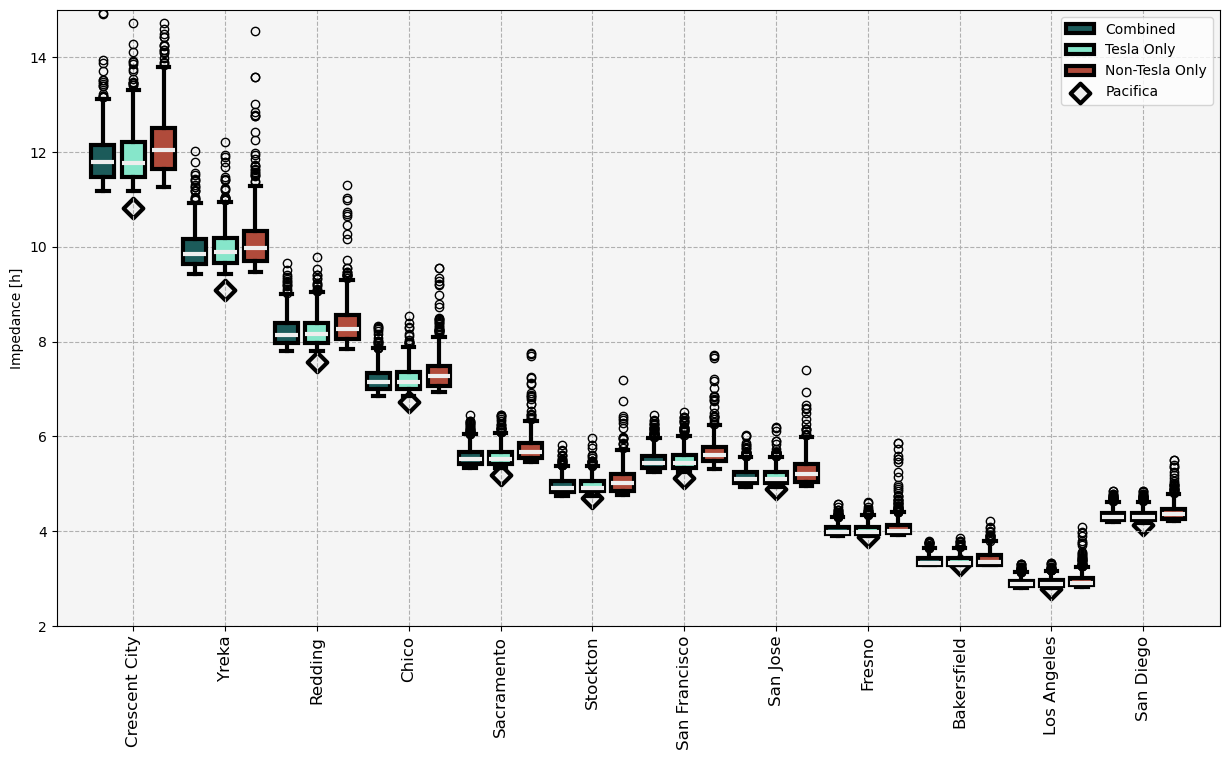

In [204]:
x0 = [df[df['graph_index'] == 0][k] for k in cities_california.nodes]
x1 = [df[df['graph_index'] == 1][k] for k in cities_california.nodes]
x2 = [df[df['graph_index'] == 2][k] for k in cities_california.nodes]

fig, ax = plt.subplots(1, 1, figsize = (15, 8))

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#1c5b5a',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp0 = ax.boxplot(x0, positions = np.arange(0, 12, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#86e6ca',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp1 = ax.boxplot(x1, positions = np.arange(.33, 12.33, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#b04b3b',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp2 = ax.boxplot(x2, positions = np.arange(.66, 12.66, 1), **kw)

kw = {
    'ec': 'k',
    'fc': '#eeeeee',
    'marker': 'D',
    'lw': 3,
    's': 100,
    'label': 'Pacifica',
}

sc0 = ax.scatter(np.arange(.33, 12.33, 1), pacifica_sri, **kw)

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'ylim': (2, 15),
}

_ = ax.set(**kw)

_ = ax.set_xticks(np.arange(.33, 12.33, 1))
_ = ax.set_xticklabels(list(cities_california.nodes), rotation = 90, fontsize = 12)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], sc0],
    ['Combined', 'Tesla Only', 'Non-Tesla Only', 'Pacifica'],
    loc = 'upper right',
)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Specific_Impedance_2.png', bbox_inches = 'tight', dpi = 300)

In [586]:
1 / .65

1.5384615384615383

In [587]:
60 / 130

0.46153846153846156

In [589]:
60 / (1 / .65 * 60 - 5 + 45)

0.4534883720930233